# RVAA - RealVsAiArt-based model
This notebook contains the code of our attempts at training a model on the RVAA dataset. 

The RVAA dataset contains around 2k images, which can either be real or AI-generated. However, unlike CIFAKE, the images are completely heterogenous: they have different resolution, different aspect-ratios and even different RGB formats (i.e. some of them are JPEGs while others are PNGs, which will also have an Alpha component).

In addition, some of the images tagged as AI-generated are only "partially" so: in some cases, an image from a diffusion model will be shown side-by-side with a real image, or text will be present all over the image. This can pose quite the challenge for our model.

Nevertheless, the we were able to achieve pretty good results, thanks in part to the employment of data augmentation.

In [1]:
import torch
from torchvision.models import resnet50
import model_utils
import plotter
import data_utils
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
import importlib
import pandas as pd
import torchvision.transforms as transforms
import xai

seed=42
model_utils.fix_random(seed)

TRAINING_MODE=True
plotter.set_display_mode(True)

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # fixes PIL warning

In [2]:
dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt")
df_stats = data_utils.get_dataset_stats(dataset)
pd.DataFrame.from_dict(df_stats, orient='index')

# size of image to resize
IMG_SIZE = 224
DATASET_NAME = 'RVAA'

In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize(IMG_SIZE),                  # Resize the shorter side to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square),  # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),      # Ensure the final image is exactly IMG_SIZExIMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)

LEARNING_RATE = 3e-4
EPOCHS = 20
BATCH_SIZE = 32

# WARNING: IF YOU REBUILD THE DATALOADER, THE RESULT WILL DIFFER. RESTART THE KERNEL AND TRAIN AGAIN TO HAVE THE SAME RESULTS.
train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.15), dataset=dataset, isRandom=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

loss_fn = nn.BCEWithLogitsLoss()
device = model_utils.get_device()
print(f"using {device} device")

dataloaders = (train_dataloader, val_dataloader)

using cuda device


## Baseline CNN training
To get a baseline for the performance of how dataset performs, we've decided to train a model from the ground up, which serves as a baseline. The model consists on a CNN with the following specifications:
- 3 Convolutional Layers:
    - Conv1: input channels = 3, output channels = 32, kernel size = 3x3.
    - Conv2: input channels = 32, output channels = 64, kernel size = 3x3.
    - Conv3: input channels = 64, output channels = 128, kernel size = 3x3.
- 3 Fully Connected layers:
    - fc1: maps the flattened tensor to 512 features.
    - fc2: maps 512 features to 256.
    - fc3: outputs predictions for the number of classes (num_classes).

Using 3 layers with a 3x3 kernel is usually a popular choice for this kind of models, as represents a good balance between model complexity and training feasibility.

In [4]:
baseline_model = model_utils.CNN()
baseline_model.to(device)
model_name = "RVAA_BaseCNN"
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)

In [5]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              baseline_model, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 56.6%, Avg loss: 0.754098
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 60.7%, Avg loss: 0.641704
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 58.6%, Avg loss: 0.867344


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 66.2%, Avg loss: 0.702516


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 61.4%, Avg loss: 0.757279


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 62.8%, Avg loss: 0.797080


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 62.8%, Avg loss: 0.881580


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 64.8%, Avg loss: 0.918233


Epoch 9/20
-------------------------------
Validation Error:
Accuracy: 58.6%, Avg loss: 0.

Test Error:
Accuracy: 76.7%, Avg loss: 0.567444
Confusion matrix report, tp: 45, fp: 17, fn: 17, tn:67
True


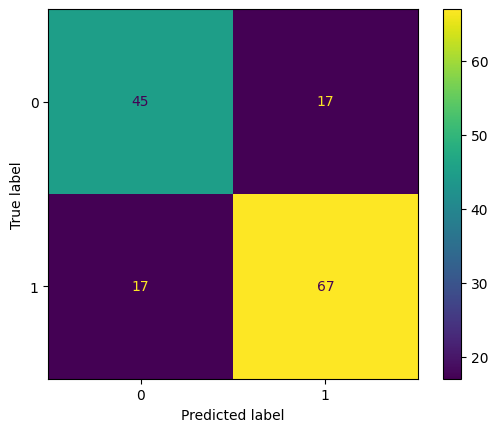

Precision: 0.73, Recall: 0.73, F1-Score: 0.73


(0.5674443006515503, tensor(0.7671, device='cuda:0'))

In [6]:
model_utils.test(test_dataloader, baseline_model, loss_fn, device,
                 model_name=model_name)

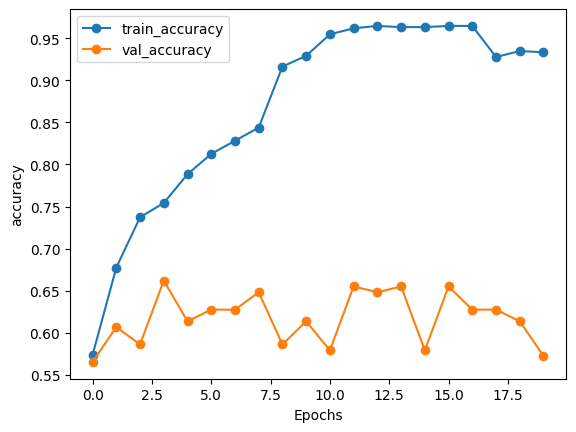

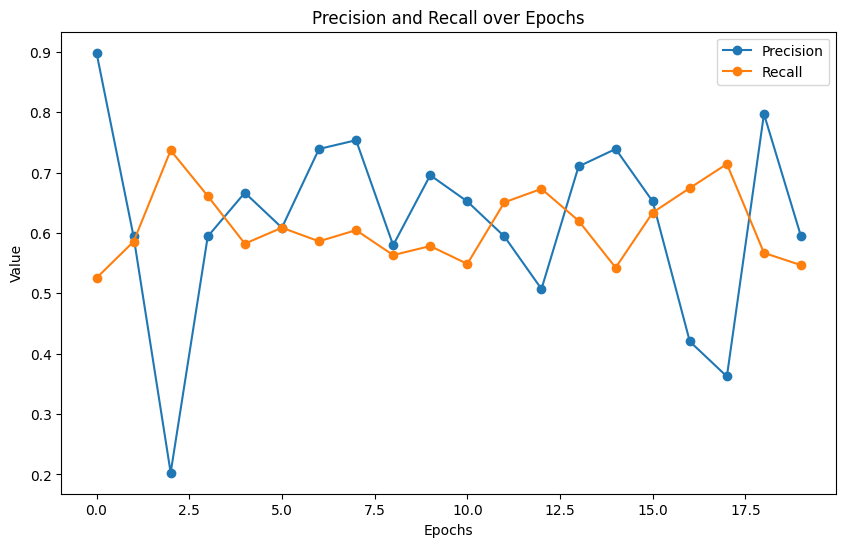

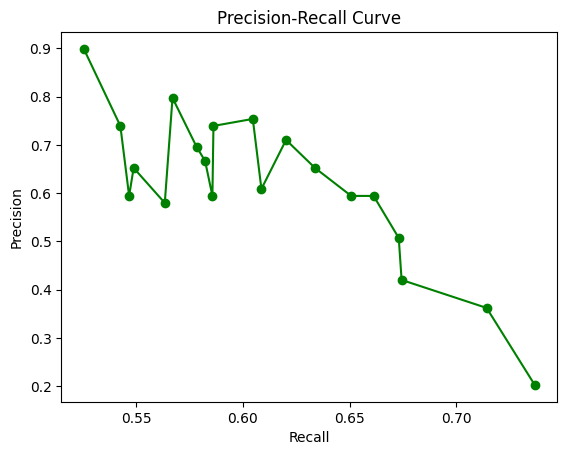

In [7]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### Finetuned ResNet50
Just as we did in CIFAKE notebook, we finetune a ResNet50 model. This is one of the most popular choices when dealing with Image Classification tasks, and it's great at finding the subtle patterns which can be found in an AI-generated image.

Just like in the CIFAKE notebook, we employ a 2-step training process. In the first step, we train only the classification head.

In [8]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=2)
ft_resnet50.to(device)

optimizer = torch.optim.Adam(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50"

In [9]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              ft_resnet50, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 59.3%, Avg loss: 0.675479
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 70.3%, Avg loss: 0.631803
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 70.3%, Avg loss: 0.609888
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 76.6%, Avg loss: 0.592564
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 77.2%, Avg loss: 0.578013
New best model found! (based on lowest loss)
...and saved.


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 75.2%, Avg loss: 0.565485
New best model found! (based on lowest loss)
...and saved.


Epoch 7/20
-------------------------------
Validatio

Test Error:
Accuracy: 78.8%, Avg loss: 0.486834
Confusion matrix report, tp: 47, fp: 15, fn: 16, tn:68
True


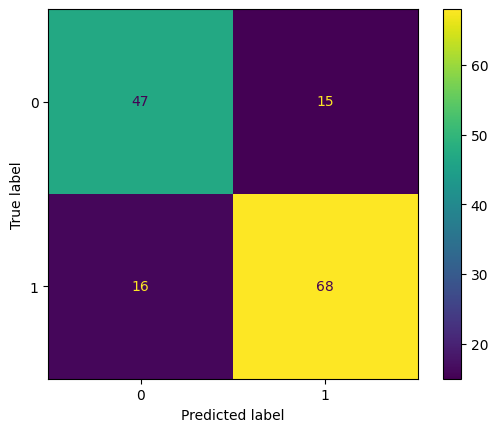

Precision: 0.76, Recall: 0.75, F1-Score: 0.75


(0.48683398962020874, tensor(0.7877, device='cuda:0'))

In [10]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

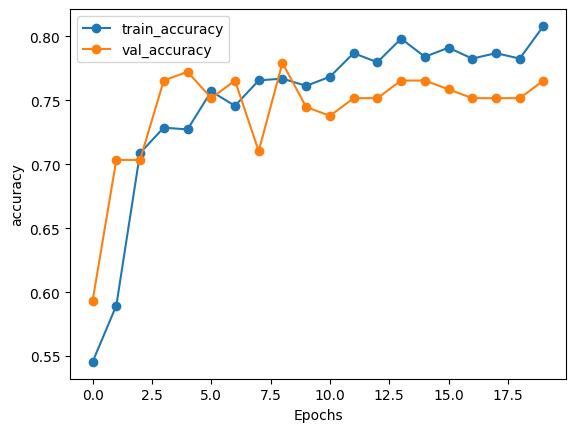

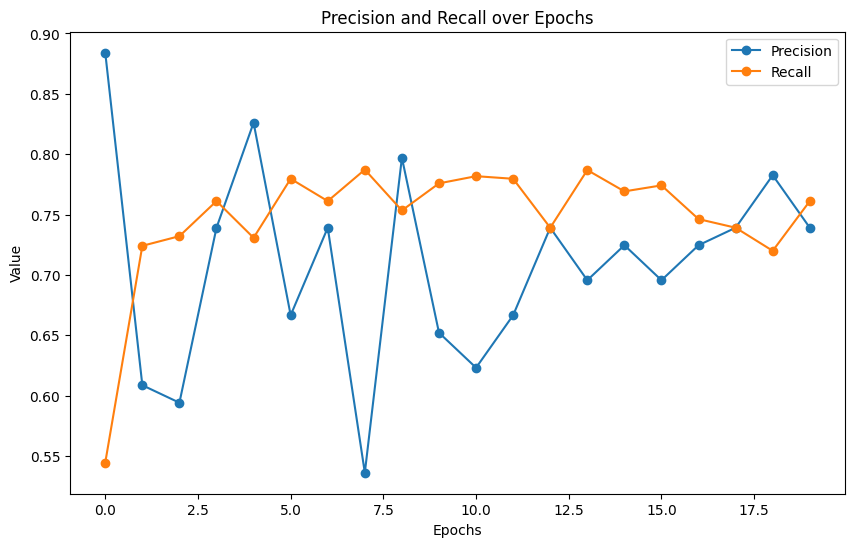

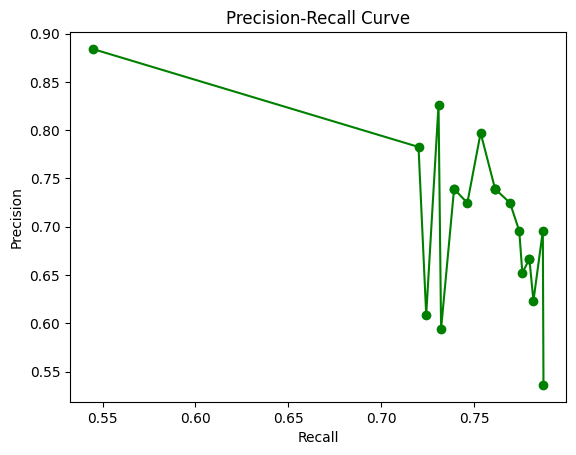

In [11]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

## Finetuning Step 2
In the second step, we train the feature extractor of the ResNet50.

In [12]:
for param in ft_resnet50.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_beefy"

In [13]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 54.5%, Avg loss: 4.624712
New best model found! (based on lowest loss)


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 64.8%, Avg loss: 1.786794
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 69.0%, Avg loss: 1.058747
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 75.9%, Avg loss: 0.691793
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 73.8%, Avg loss: 0.700166


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 71.7%, Avg loss: 1.067725


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 60.7%, Avg loss: 1.615423


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 71.0%, Avg los

Test Error:
Accuracy: 81.5%, Avg loss: 0.633591
Confusion matrix report, tp: 54, fp: 8, fn: 19, tn:65
True


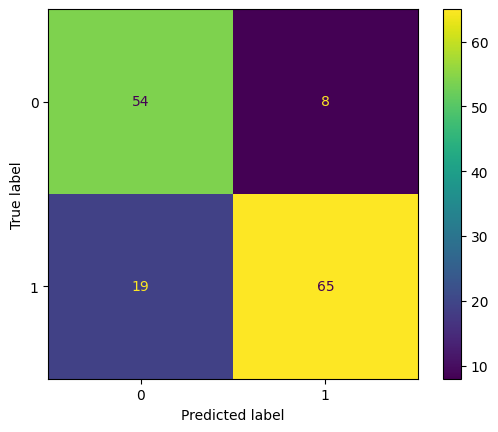

Precision: 0.87, Recall: 0.74, F1-Score: 0.80


(0.6335905432701111, tensor(0.8151, device='cuda:0'))

In [14]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

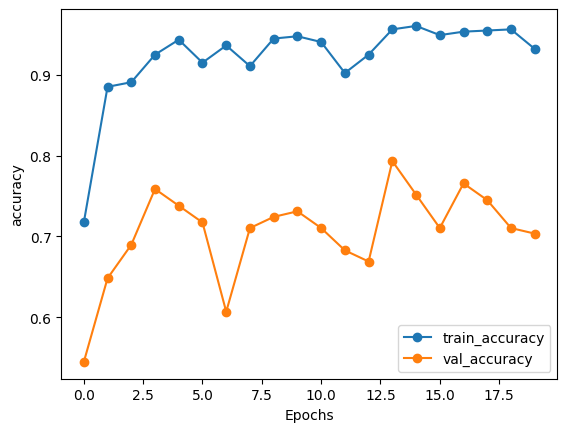

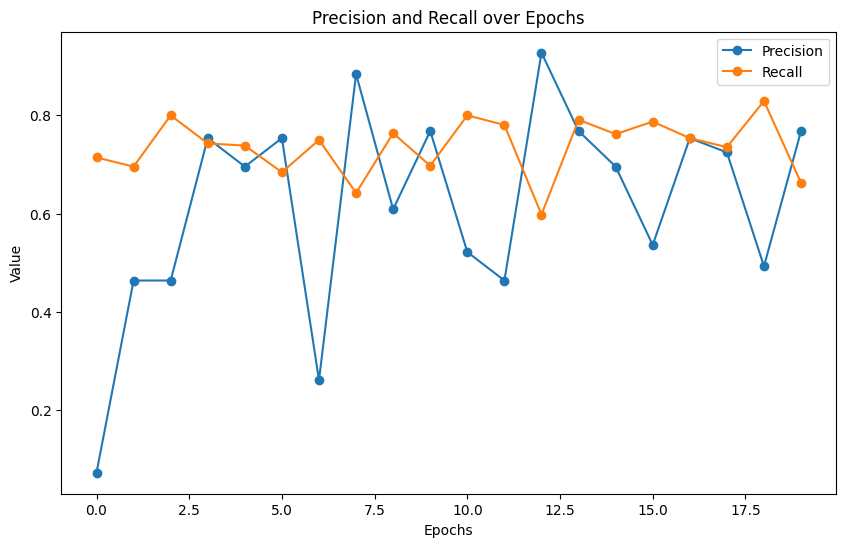

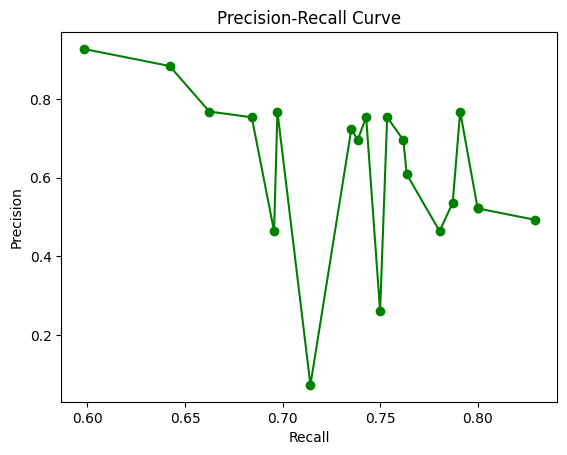

In [15]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

## xAI samples
We apply AblationCAM, ScoreCAM and LIME to the images to get an explanation on the outcomes achieved by the model.

### AblationCAM/ScoreCAM

100%|██████████| 64/64 [00:05<00:00, 12.17it/s]


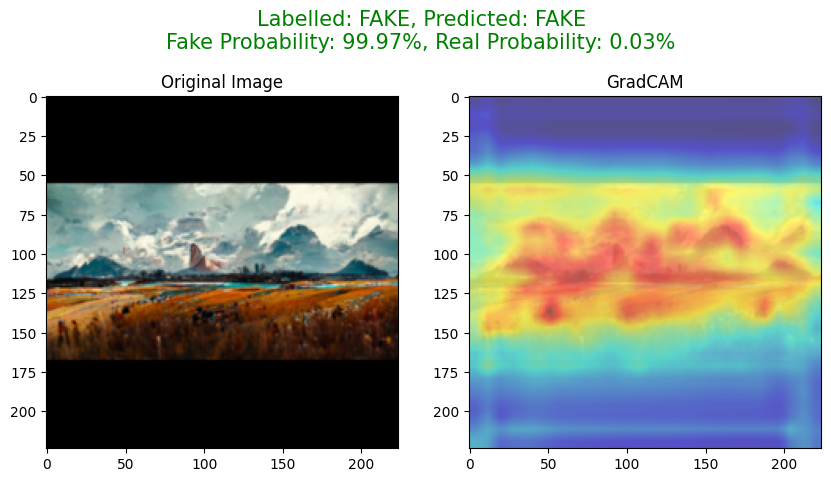

In [16]:
xai.set_device(device)
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 16)

RVAA really shows the power of using AblationCAM with these images: when put side-by-side, it provides a very readable explanation which allows to really capture the details that make an image AI-generated (or not).

100%|██████████| 64/64 [00:03<00:00, 19.66it/s]


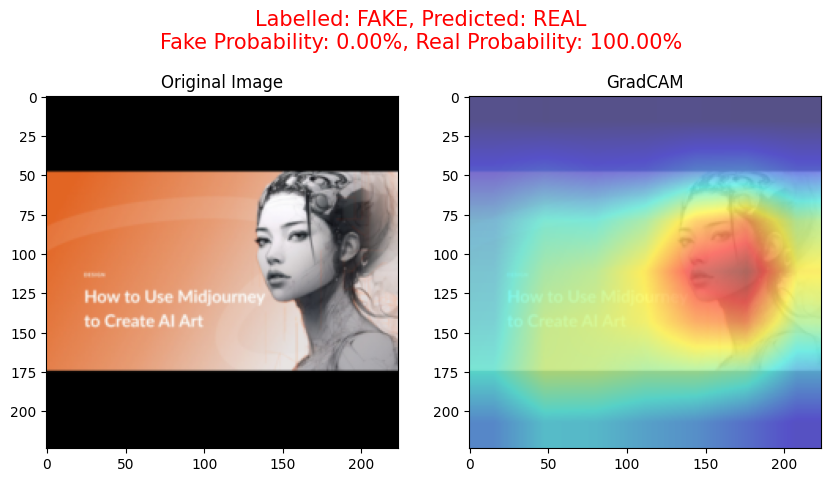

In [17]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2)

In this case, applying AblationCAM on only the last 2 layers gives a not very defined blob. It is interesting to see also how the heatmap of this misclassification (done on a very difficult sample of the dataset) has some color on the text, indicating that the presence of text played a part on the misclassification.

100%|██████████| 128/128 [00:04<00:00, 27.45it/s]


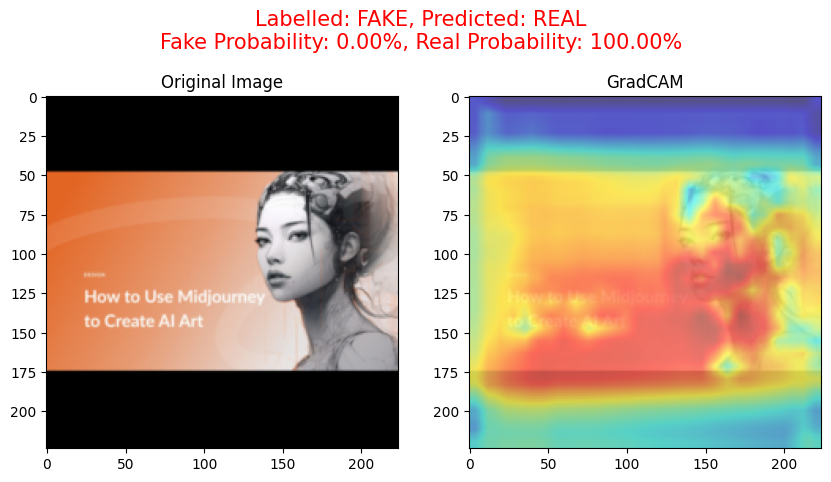

In [18]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2,
                                mapper="sc")

On the other hand, ScoreCAM gives out a much more defined blob, however the explanation isn't as usable as the one received from AblationCAM. In a sense, we're in the opposite situation from the one seen before.

100%|██████████| 128/128 [00:03<00:00, 35.82it/s]


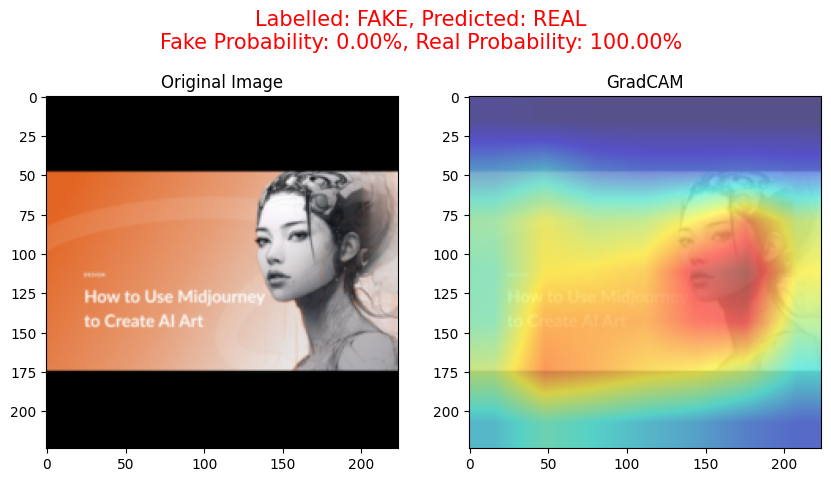

In [19]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50,
                                ft_resnet50.layer4,
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2,
                                mapper="sc")

On the other hand, applying ScoreCAM to less labels gives a less defined blob (like in the AblationCAM example), however it captures details that are usually found in real images (i.e. the text, smoothed out noise in the portrait's face).

### LIME experiment

  0%|          | 0/1000 [00:00<?, ?it/s]

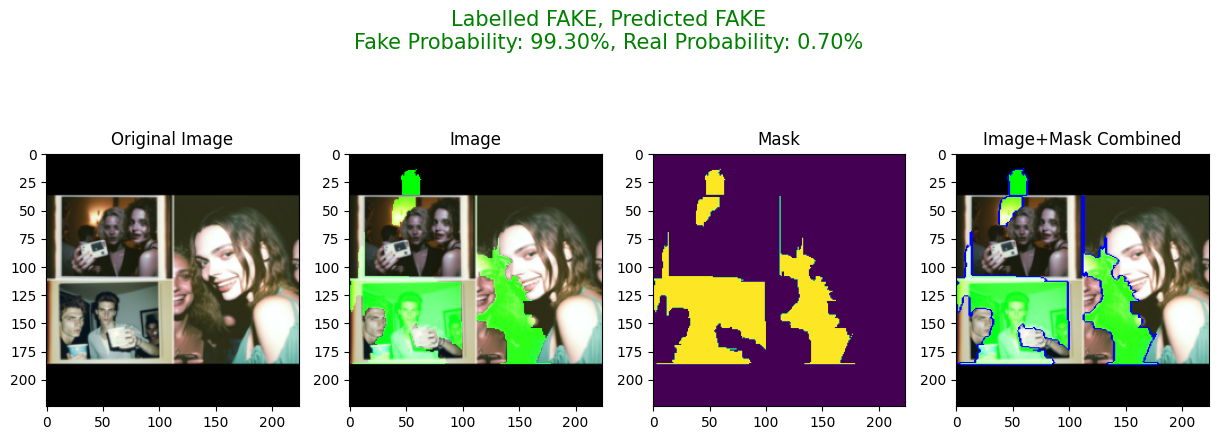

In [20]:
xai.explain_lime_single_image(test_dataloader, ft_resnet50,
                              model_name = model_name, dataset_name = DATASET_NAME,
                              index = 3)

As seen in this example, LIME is not so great in giving explanations for single labelled classification tasks. While the higher resolution image help LIME, and decrease the likelihood of broken explanations, the results do not provide a satisfying explanation of the reasoning of the model.

### xAI batch visualizations
This code allows us to save some samples of a batch of AblationCAM and LIME, and it's only for data analysis purposes.

In [21]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=2)
ft_resnet50.to(device)
ft_resnet50.load_state_dict(torch.load("checkpoints/best_RVAA_FTRes50_beefy.pth"))
model_name = "FTRes50_beefy"

C:\Users\tekke\AppData\Local\Temp\ipykernel_19144\3033350679.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_resnet50.load_state_dict(torch.load("checkpoints/best_RVA

In [ ]:
xai.explain_gradcam_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50, [ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4], model_name, DATASET_NAME)

In [ ]:
xai.explain_lime_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50,
                        model_name=model_name, dataset_name=DATASET_NAME,
                        )

### Data Augmentation Experiment
Since by using this pipeline we've achieved great performance in CIFAKE (which did not improve by changing the model structure), we've concluded one of the ways that we could attempt to improve performance would be working on the data itself. 

Unlike CIFAKE, which contains over 120'000 samples, RVAA contains 1200 samples, which may not be enough data to reach the capacity of a model such as ResNet50. As such, we've decided to experiment with data augmentation, which will allow our model to generalize better.

In [24]:
augmented_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize(IMG_SIZE),                 # Resize to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square), # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is IMG_SIZExIMG_SIZE
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(90),  # Randomly rotate the image by up to 90 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

In [25]:
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np
import copy
import random

original_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)
# make a deepcopy to ensure it has the same order
dataset_copy = copy.deepcopy(original_dataset)

# we are doing the same thing as the train_test_split function
train_size = int(0.7 * len(original_dataset))
val_size = int(0.15 * len(original_dataset))
test_size = len(original_dataset) - train_size - val_size

generator = torch.Generator()
generator.manual_seed(seed)
train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(original_dataset)),
    [train_size, val_size, test_size],
    generator=generator
)

train_dataset = Subset(original_dataset, train_indices)
val_dataset = Subset(original_dataset, val_indices)
test_dataset = Subset(original_dataset, test_indices)

augmented_size = int(0.8 * len(train_dataset))
augmented_indices = random.sample(train_indices.indices, augmented_size)

dataset_copy.transform = augmented_transform
augmented_train_dataset = Subset(dataset_copy, augmented_indices)

combined_train_dataset = ConcatDataset([train_dataset, augmented_train_dataset])

In [26]:
# Ensure augmented indices are within the training set
assert set(augmented_indices).issubset(train_indices), "Augmented indices include non-training data!"

# Ensure no overlap between validation and augmented data
assert not set(val_indices).intersection(augmented_indices), "Data leakage in validation set!"

# Ensure no overlap between test and augmented data
assert not set(test_indices).intersection(augmented_indices), "Data leakage in test set!"

In [27]:
print(len(train_dataset), len(combined_train_dataset))

679 1222


In [28]:
train_dataloader = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = (train_dataloader, val_dataloader)

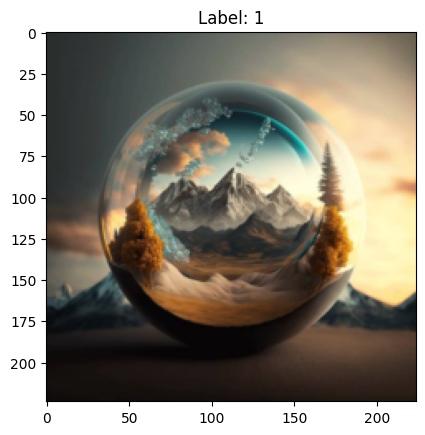

In [29]:
data_utils.show_random_sample(train_dataloader)

As always, we employ a 2-step training procedure.

In [30]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=2)
ft_resnet50.to(device)

optimizer = torch.optim.Adam(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_experiment"


In [31]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 54.5%, Avg loss: 0.656013
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 56.6%, Avg loss: 0.628924
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 73.1%, Avg loss: 0.590387
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 74.5%, Avg loss: 0.572798
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 69.7%, Avg loss: 0.574362


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 76.6%, Avg loss: 0.549385
New best model found! (based on lowest loss)
...and saved.


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 72.4%, Avg loss: 0.559922


Epoch 8/20
-

Test Error:
Accuracy: 80.1%, Avg loss: 0.455850
Confusion matrix report, tp: 49, fp: 13, fn: 16, tn:68
True


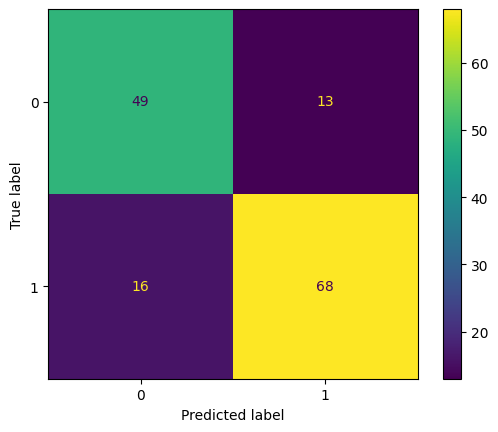

Precision: 0.79, Recall: 0.75, F1-Score: 0.77


(0.4558499753475189, tensor(0.8014, device='cuda:0'))

In [32]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

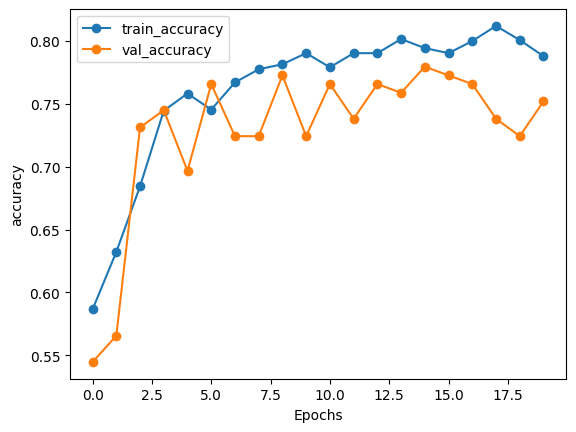

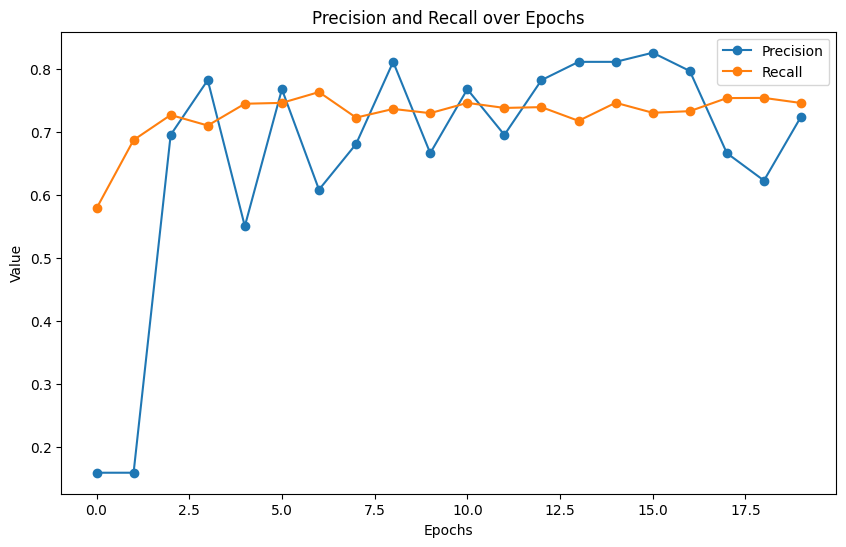

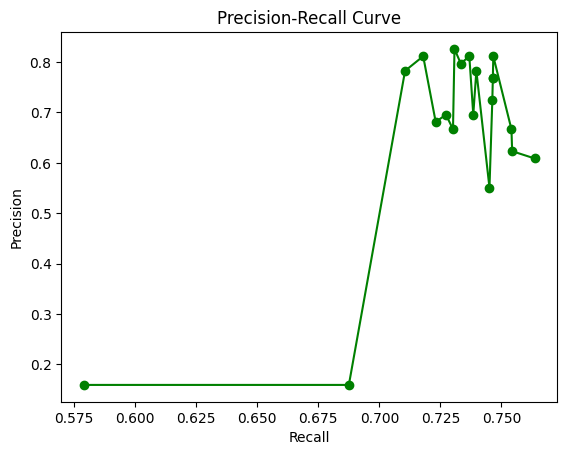

In [33]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

In [34]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.Adam(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_experiment_beefy"

In [35]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 71.0%, Avg loss: 0.572472
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 69.0%, Avg loss: 0.774055


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 79.3%, Avg loss: 0.600561


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 73.1%, Avg loss: 0.727081


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 74.5%, Avg loss: 0.736413


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 68.3%, Avg loss: 0.865549


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 71.0%, Avg loss: 0.752277


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 73.8%, Avg loss: 0.871801


Epoch 9/20
-------------------------------
Validation Error:
Accuracy: 73.1%, Avg loss: 0.742362


Epoch 10/20
-------------------------------
Valida

Test Error:
Accuracy: 86.3%, Avg loss: 0.401380
Confusion matrix report, tp: 53, fp: 9, fn: 11, tn:73
True


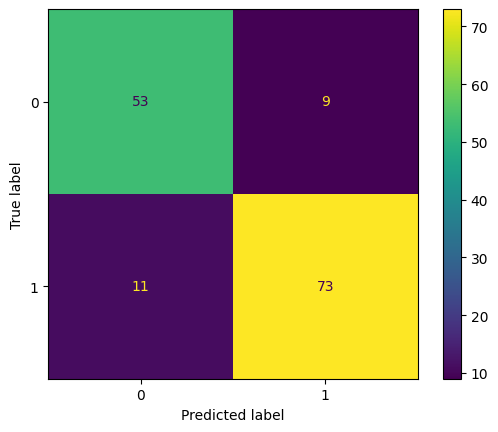

Precision: 0.85, Recall: 0.83, F1-Score: 0.84


(0.40137979984283445, tensor(0.8630, device='cuda:0'))

In [36]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

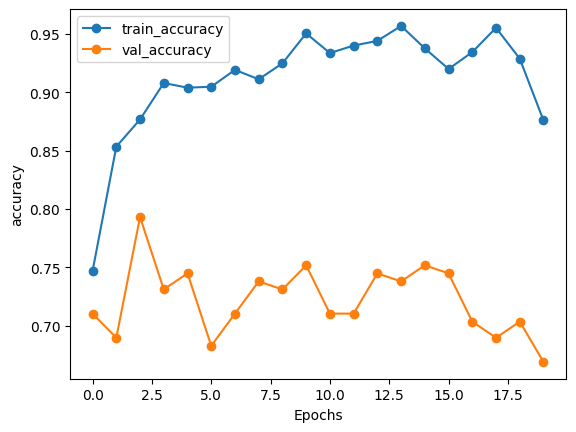

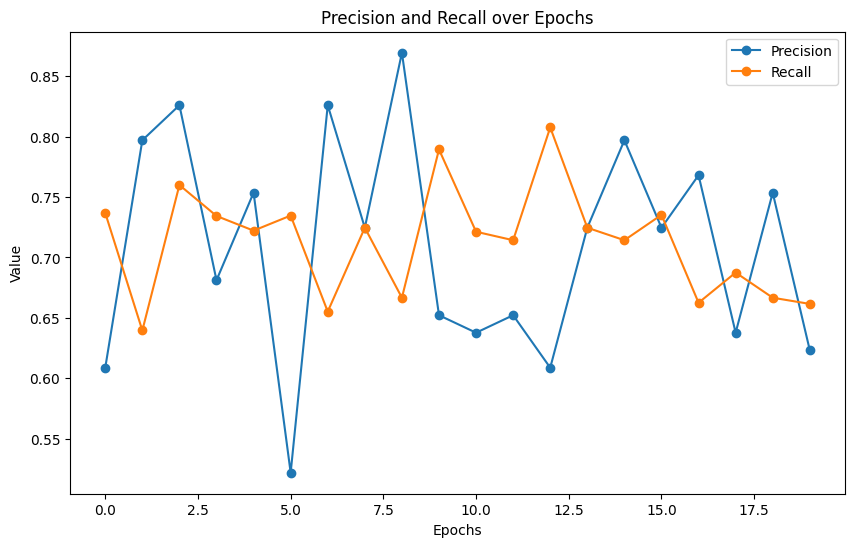

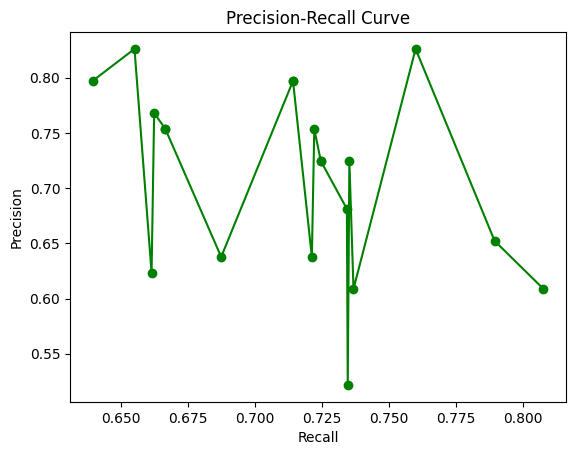

In [37]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

Ultimately, data augmentation allows for a significant performance uplift, as it allows to improve performance of about 5%.